In [1]:
import os

from dotenv import load_dotenv
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download
import matplotlib.pyplot as plt

load_dotenv()
hugging_face_token = os.getenv('HUGGING_FACE_TOKEN')

In [2]:
login(
    token=hugging_face_token
)  # login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "/workspaces/histolung/models/uni/assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
hf_hub_download("MahmoodLab/UNI",
                filename="pytorch_model.bin",
                local_dir=local_dir,
                force_download=False)
model = timm.create_model("vit_large_patch16_224",
                          img_size=224,
                          patch_size=16,
                          init_values=1e-5,
                          num_classes=0,
                          dynamic_img_size=True)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"),
                                 map_location="cpu"),
                      strict=True)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])
model.eval()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/vscode/.cache/huggingface/token
Login successful


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

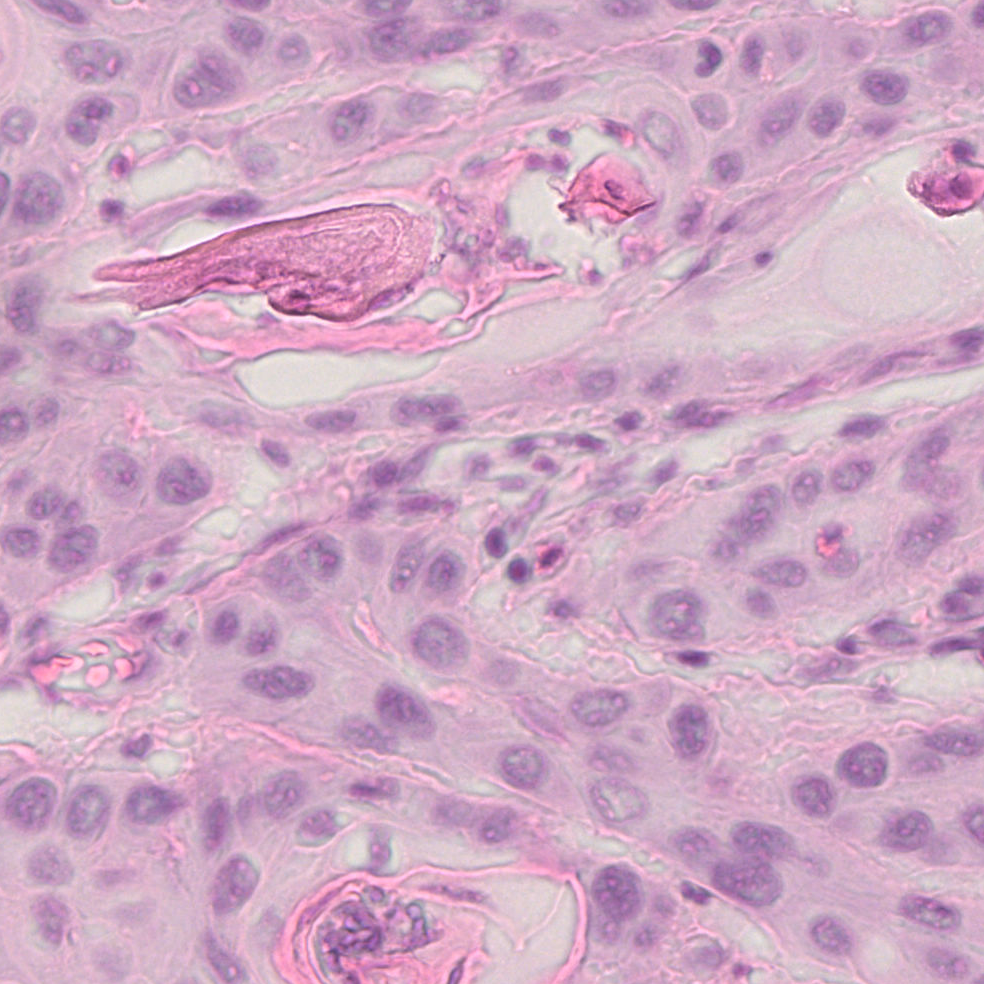

In [3]:

image = Image.open("/workspaces/histolung/data/raw/SegPath/panCK/panCK_Epithelium/panCK_Epithelium_023_011264_009216_HE.png").convert('RGB')
image

In [4]:
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
    feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,1024]

In [5]:
im = np.transpose(np.squeeze(image.numpy()), (1, 2, 0))
im.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9677871..2.4831376].


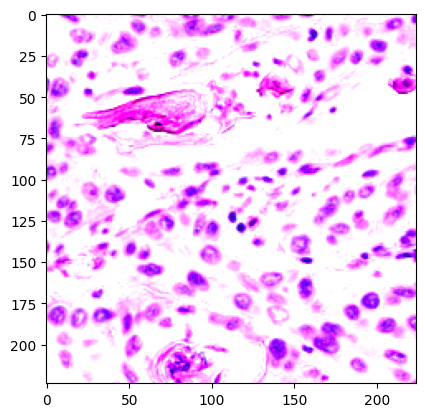

In [6]:
plt.imshow(im)